## Setup

Import the github repository and move it into the local directory (also remove the defult samples directoy if it exists)

In [1]:
from getpass import getpass
import os

user = "mattiaguerri"
password = getpass('BitBucket password')
os.environ['BITBUCKET_AUTH'] = user + ':' + password

!rm -r sample_data/
!git clone https://$BITBUCKET_AUTH@github.com/msc-acse/acse-8-miniproject-softmax.git repo
!mv repo/* .
!mv repo/.git .
!rm -r repo

BitBucket password··········
Cloning into 'repo'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 178 (delta 90), reused 125 (delta 46), pack-reused 0
Receiving objects: 100% (178/178), 26.48 MiB | 21.87 MiB/s, done.
Resolving deltas: 100% (90/90), done.


Move to correct github branch

In [2]:
# !rm tools.py
# !git checkout mattia
# !git reset --hard
!git pull origin mattia
!ls -l

From https://github.com/msc-acse/acse-8-miniproject-softmax
 * branch            mattia     -> FETCH_HEAD
Updating e3f639f..4774ee8
Fast-forward
 models/Reduced_AlexNet_01.xlsx | Bin 0 -> 9910 bytes
 training/AlexNet.ipynb         | 964 +++++++++++++++++++++++++++++++++++++++++
 training/LeNet6.ipynb          | 815 ++++++++++++++++++++++++++++++++++
 3 files changed, 1779 insertions(+)
 create mode 100644 models/Reduced_AlexNet_01.xlsx
 create mode 100644 training/AlexNet.ipynb
 create mode 100644 training/LeNet6.ipynb
total 32
drwxr-xr-x 2 root root 4096 May 21 10:20 data
drwxr-xr-x 2 root root 4096 May 21 10:20 models
-rw-r--r-- 1 root root  771 May 21 10:20 README.md
drwxr-xr-x 2 root root 4096 May 21 10:20 spec
-rw-r--r-- 1 root root 8591 May 21 10:20 tools.py
drwxr-xr-x 2 root root 4096 May 21 10:20 training


Ipython imports and functions

In [3]:
# ipython setup
!pip install pycm livelossplot
%pylab inline
%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 51kB 3.4MB/s 
     |████████████████████████████████| 491kB 11.4MB/s 
     |████████████████████████████████| 215kB 50.0MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 4.5.3 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
Populating the interactive namespace from numpy and matplotlib


Module imports

In [4]:
# imports
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, RandomCrop, ToPILImage

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

# imports from github
from tools import *

# check they worked
set_seed(0)

True

Check runtime device

In [5]:
# check running device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Load Data

In [0]:
train_feat = np.load("/content/data/kmnist-train-imgs.npy")
train_targ = np.load("/content/data/kmnist-train-labels.npy")
test_feat = np.load("/content/data/kmnist-test-imgs.npy")

In [7]:
# check what the data looks like
for data, data_name in zip([train_targ, test_feat, train_feat], 
                           ["train_targ", "test_feat", "train_feat"]):
    
    print(data_name)
    
    for name, code in zip(["shape", "mean", "std", "max", "min", "type", "cuda"],
                          ["data.shape", "data.mean()", "data.std()", 
                           "data.max()", "data.min()", "data.dtype"]):
        try:
            exec("print('\t', name, '\t:\t', " + code + ")")
        except:
            print("\t", name, "\t:\t undefined")

train_targ
	 shape 	:	 (60000,)
	 mean 	:	 4.5
	 std 	:	 2.8722813232690143
	 max 	:	 9
	 min 	:	 0
	 type 	:	 uint8
test_feat
	 shape 	:	 (10000, 28, 28)
	 mean 	:	 47.06204145408163
	 std 	:	 87.1110021912918
	 max 	:	 255
	 min 	:	 0
	 type 	:	 uint8
train_feat
	 shape 	:	 (60000, 28, 28)
	 mean 	:	 48.89934757653061
	 std 	:	 88.82742173832395
	 max 	:	 255
	 min 	:	 0
	 type 	:	 uint8


## Data pre-processing

First put in torch type with correct shape, dtype and device

In [0]:
train_feat = torch.from_numpy(train_feat)
train_feat = train_feat.float().view(-1, 1, 28, 28)

test_feat = torch.from_numpy(test_feat)
test_feat = test_feat.float().view(-1, 1, 28, 28)

train_targ = torch.from_numpy(train_targ)
train_targ = train_targ.long()

Now set our parameters

In [0]:
# Other Hyperparameters
Seed = 42
Learning_Rate = 1e-2
Momentum = 0.5
Batch_Size = 64
Test_Batch_Size = 1000
Number_of_Epochs = 50

Divide data into n_fold sets

In [10]:
# do the split
n_folds = 10
shuffler =  StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
shuffler = shuffler.split(train_feat, train_targ)

# get the indices
indices = np.array(list(shuffler))
print(indices.shape)
print([i.shape for i in indices.flatten()])

(10, 2)
[(54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,)]


In [0]:
def create_dataset(train, targ, t_id, v_id):
    
    t_feat = train[t_id]
    v_feat = train[v_id]
    t_targ = targ[t_id]
    v_targ = targ[v_id]
    
    # find mean and std
    mean, std = torch.mean(t_feat).item(), torch.std(t_feat).item()
    
    # includes data augmentation
    train_transform = Compose([
        Normalize(mean=[mean], std=[std]),
        ])

    # only want to normalize here
    validation_test_transform = Compose([
        Normalize(mean=[mean], std=[std]),
        ])
    
    # create the custom datasets
    train_set = CustomImageTensorDataset(t_feat, t_targ, transform=train_transform)
    valid_set = CustomImageTensorDataset(v_feat, v_targ, transform=validation_test_transform)

    return train_set, valid_set

In [12]:
data_loders = []
for t_index, v_index in indices:
    t_set, v_set = create_dataset(train_feat, train_targ, t_index, v_index)
    data_loders.append([ DataLoader(t_set, batch_size=Batch_Size, shuffle=True),
                         DataLoader(v_set, batch_size=Test_Batch_Size, shuffle=False)])
    
data_loders = np.array(data_loders)
data_loders.shape

(10, 2)

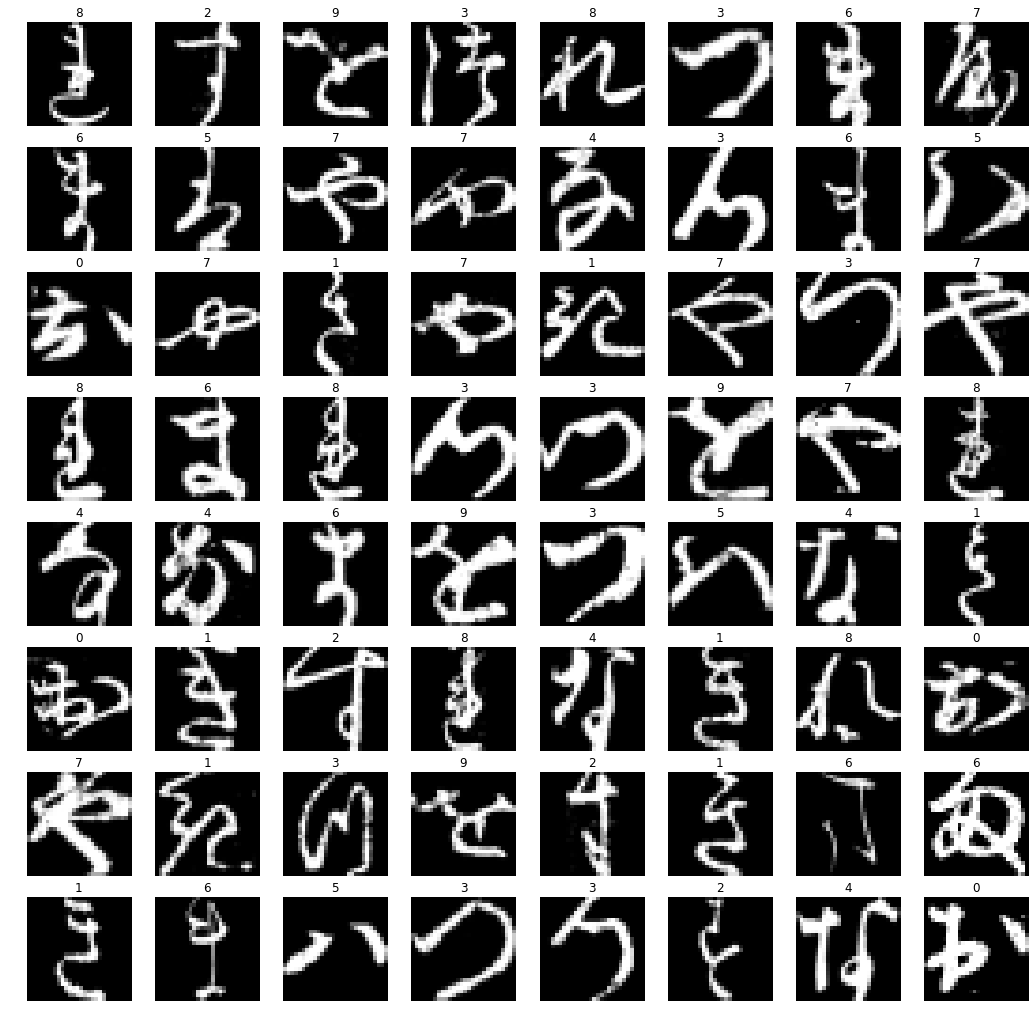

In [13]:
for X, y in data_loders[0][0]:
    
    fig, axs = plt.subplots(8, 8, figsize=[18, 18])
    for img, lab, ax in zip(X, y, axs.flatten()):
        ax.imshow(img[0], cmap='gray')
        ax.axis("off")
        ax.set(title=str(lab.item()))
    break

## Define the Networks

In [0]:
# LeNet5
class LeNet5_dropout(nn.Module):
    """
    The LeNet5 neural network architecture with dropout on first two layers
    """

    def __init__(self, bias=True):
        "setup the neural network"
        
        # initalise
        super(LeNet5, self).__init__()

        # create each layer
        act = nn.ReLU()
        
        self.convolutional = nn.Sequential(
            nn.Conv2d(1, 6, padding=2, kernel_size=5, stride=1, bias=bias), act,
            nn.Dropout2d(),
            nn.MaxPool2d(kernel_size=2, stride=2), act,
            nn.Conv2d(6, 16, padding=0, kernel_size=5, stride=1, bias=bias), act,
            nn.Dropout2d(),
            nn.MaxPool2d(kernel_size=2, stride=2), act)
        
        self.full_connected = nn.Sequential(
            nn.Linear(16*5*5, 120, bias=bias), act,
            nn.Linear(120,84, bias=bias), act,
            nn.Linear(84, 10, bias=bias)
        )

    def flatten(self, T):
        "flatten the image for the fully connected layers"
        return T.view(-1, T.size(1) * T.size(2) * T.size(3))
        
        
    def forward(self, x):
        "Pass through the neural network"
        x = self.convolutional(x)
        x = self.flatten(x)
        x = self.full_connected(x)
        return x

In [0]:
# AlexNet_half (sequential)
class AlexNet_half(nn.Module):
    """
    Neural Network inspired on Alexnet, with a reduced number of parameters (989410).
    """

    def __init__(self, bias=True):
        "setup the neural network"
        
        # initalise
        super(AlexNet_half, self).__init__()

        # create the activation function
        act = nn.ReLU()
        
        self.convolutional = nn.Sequential(
            nn.Conv2d(1, 24, padding=1, kernel_size=4, stride=1, bias=bias), act,
            nn.MaxPool2d(kernel_size=1, stride=1), act,
            nn.Conv2d(24, 64, padding=2, kernel_size=5, stride=1, bias=bias), act,
            nn.MaxPool2d(kernel_size=3, stride=2), act,
            nn.Conv2d(64, 96, padding=2, kernel_size=5, stride=1, bias=bias), act,
            nn.Conv2d(96, 96, padding=1, kernel_size=3, stride=1, bias=bias), act,
            nn.Conv2d(96, 64, padding=1, kernel_size=3, stride=1, bias=bias), act,
            nn.MaxPool2d(kernel_size=3, stride=2), act)
        
        self.full_connected = nn.Sequential(
            nn.Linear(2304, 256, bias=bias), act,
            nn.Linear(256, 256, bias=bias), act,
            nn.Linear(256, 10, bias=bias)
        )

    def flatten(self, T):
        "flatten the image for the fully connected layers"
        return T.view(-1, T.size(1)*T.size(2)*T.size(3))
        
        
    def forward(self, x):
        "Pass through the neural network"
        x = self.convolutional(x)
        x = self.flatten(x)
        x = self.full_connected(x)
        return x

## Model Training

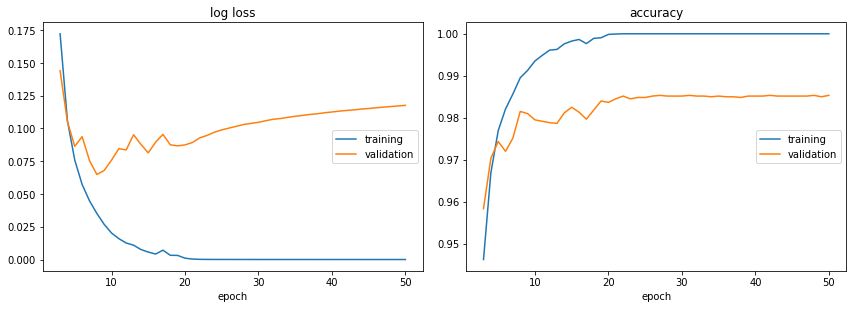

log loss:
training   (min:    0.000, max:    1.978, cur:    0.000)
validation (min:    0.065, max:    0.777, cur:    0.118)

accuracy:
training   (min:    0.275, max:    1.000, cur:    1.000)
validation (min:    0.750, max:    0.985, cur:    0.985)
Training Finished


In [16]:
set_seed(Seed)
model = AlexNet_half().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=Learning_Rate, momentum=Momentum)
criterion = nn.CrossEntropyLoss()
train_loader, validate_loader = data_loders[0]

wrapper = train_wrapper(model, optimizer, train_loader, validate_loader, 
                        criterion=criterion, device=device)
wrapper.train_model(Number_of_Epochs)

In [20]:
wrapper.save_model("AlexNet_50.pth", path="/")
test = torch.load("/AlexNet_50.pth")

saved to /AlexNet_50.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type AlexNet_half. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [21]:
test

{'model': AlexNet_half(
   (convolutional): Sequential(
     (0): Conv2d(1, 24, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
     (3): ReLU()
     (4): Conv2d(24, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): ReLU()
     (8): Conv2d(64, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (9): ReLU()
     (10): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU()
     (12): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU()
     (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (15): ReLU()
   )
   (full_connected): Sequential(
     (0): Linear(in_features=2304, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=25

In [19]:
!pwd

/content
